In [0]:
"""
    [metric learningの実験]
    実験対象：L2 Softmax loss
"""

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d
#%matplotlib notebook


def show_2D_tSNE(latent_vecs, target, title='t-SNE viz'):
    latent_vecs = latent_vecs
    latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()


def show_3D_tSNE(latent_vecs, target, title='3D t-SNE viz'):
    latent_vecs = latent_vecs
    tsne = TSNE(n_components=3, random_state=0).fit_transform(latent_vecs)
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter3D(tsne[:, 0], tsne[:, 1], tsne[:, 2], c=target, cmap='jet')
    ax.set_title(title)
    plt.colorbar(scatter)
    plt.show()


def show_as_PCA(latent_vecs, target, title='PCA viz'):
    latent_vecs = latent_vecs
    #latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    latent_vecs_reduced = PCA(n_components=2).fit_transform(latent_vecs)
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()

In [0]:
import os

def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [0]:
from fastai.vision import *
from torchvision import datasets, transforms
from torch import nn
import PIL
from tqdm import tqdm
#from dlcliche.image import *
import os

def prepare_full_MNIST_databunch(data_folder, tfms):
    """
    Prepare dataset as images under:
        data_folder/images/('train' or 'valid')/(class)
    where filenames are:
        img(class)_(count index).png
    """
    train_ds = datasets.MNIST(data_folder, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.Normalize((0.1307,), (0.3081,))
                          ]))
    valid_ds = datasets.MNIST(data_folder, train=False,
                              transform=transforms.Compose([
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    def ensure_folder(folder):
        if not os.path.exists(folder):
          os.makedirs(folder)
    def have_already_been_done():
        return (data_folder/'images').is_dir()
    def build_images_folder(data_root, X, labels, dest_folder):
        images = data_folder/'images'
        for i, (x, y) in tqdm(enumerate(zip(X, labels))):
            folder = images/dest_folder/f'{y}'
            ensure_folder(folder)
            x = x.numpy()
            image = np.stack([x for ch in range(3)], axis=-1)
            PIL.Image.fromarray(image).save(folder/f'img{y}_{i:06d}.png')

    if not have_already_been_done():
        build_images_folder(data_root=DATA, X=train_ds.train_data,
                            labels=train_ds.train_labels, dest_folder='train')
        build_images_folder(data_root=DATA, X=valid_ds.test_data, 
                            labels=valid_ds.test_labels, dest_folder='valid')

    return ImageDataBunch.from_folder(data_folder/'images', ds_tfms=tfms)


def body_feature_model(model):
    """
    Returns a model that output flattened features directly from CNN body.
    """
    try:
        body, head = list(model.org_model.children()) # For XXNet defined in this notebook
    except:
        body, head = list(model.children()) # For original pytorch model
    return nn.Sequential(body, head[:-1])


def get_embeddings(embedding_model, data_loader, label_catcher=None, return_y=False):
    """
    Calculate embeddings for all samples in a data_loader.
    
    Args:
        label_catcher: LearnerCallback for keeping last batch labels.
        return_y: Also returns labels, for working with training set.
    """
    embs, ys = [], []
    for X, y in data_loader:
        # For each batch (X, y),
        #   Set labels (y) if label_catcher's there.
        if label_catcher:
            label_catcher.on_batch_begin(X, y, train=False)
        #   Get embeddings for this batch, store in embs.
        with torch.no_grad():
            # Note that model's output is not softmax'ed.
            out = embedding_model(X).cpu().detach().numpy()
            out = out.reshape((len(out), -1))
            embs.append(out)
        ys.append(y)
    # Putting all embeddings in shape (number of samples, length of one sample embeddings)
    embs = np.concatenate(embs) # Maybe in (10000, 10)
    ys   = np.concatenate(ys)
    if return_y:
        return embs, ys
    return embs

In [0]:
!rm -rf data

In [21]:
DATA = Path('data')
data = prepare_full_MNIST_databunch(DATA, get_transforms(do_flip=False))

0it [00:00, ?it/s]

9920512it [00:02, 4013328.41it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56826.23it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 942569.51it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21694.75it/s]            
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


60000it [00:28, 2125.97it/s]
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
10000it [00:04, 2150.32it/s]


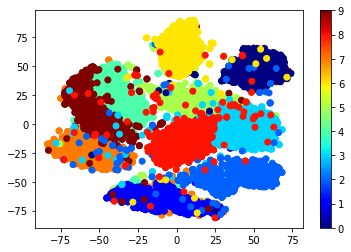

In [23]:
"""
    Raw data distribution
"""
raw_x = np.array([a.data.numpy() for a in data.valid_ds.x])
raw_y = np.array([int(y.obj) for y in data.valid_ds.y])
raw_x = raw_x.reshape((len(raw_x), -1))

if False: # for saving time
    LIMIT = 1000
    chosen_idxes = np.random.choice(list(range(len(raw_x))), LIMIT)
    raw_x = raw_x[chosen_idxes]
    raw_y = raw_y[chosen_idxes]

show_2D_tSNE(raw_x, raw_y, 'Raw sample distributions (t-SNE)')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.482075,0.289989,0.909100,01:57


epoch,train_loss,valid_loss,accuracy,time
0,0.104732,0.049213,0.986200,02:02
1,0.062258,0.034005,0.991000,02:02
2,0.061640,0.028567,0.992300,02:02


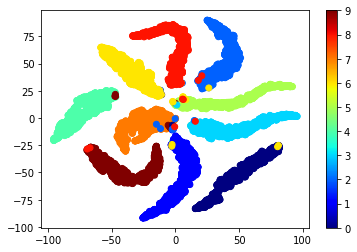

In [24]:
"""
    Conventional softmax model
"""
def learner_conventional(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.fit(1)
    learn.unfreeze()
    learn.fit(3)
    return learn

learn = learner_conventional(data)
embs = get_embeddings(body_feature_model(learn.model), data.valid_dl)
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='Simply trained ResNet18 (t-SNE)')

epoch,train_loss,valid_loss,accuracy,time
0,0.972637,0.880503,0.940400,01:54


epoch,train_loss,valid_loss,accuracy,time
0,0.805592,0.762717,0.986300,02:02
1,0.790960,0.755478,0.989700,02:02
2,0.786017,0.752064,0.992200,02:02
3,0.787097,0.754310,0.991700,02:01
4,0.783181,0.751262,0.992200,02:00


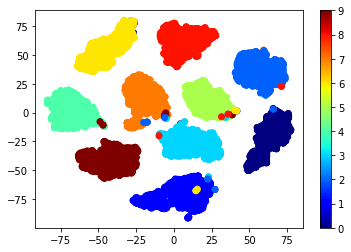

In [37]:
"""
    L2-constrained Softmax Loss
"""
class L2ConstraintedNet(nn.Module):
    def __init__(self, org_model, alpha=16, num_classes=1000):
        super().__init__()
        self.org_model = org_model
        self.alpha = alpha

    def forward(self, x):
        x = self.org_model(x)
        
        l2 = torch.sqrt((x**2).sum())
        x = self.alpha * (x / l2)
        return x

def learner_L2ConstraintedNet(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = L2ConstraintedNet(learn.model, num_classes=10)
    learn.fit(1)
    learn.unfreeze()
    learn.fit(5)
    return learn

learn = learner_L2ConstraintedNet(data)
embs = get_embeddings(body_feature_model(learn.model), data.valid_dl)
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='L2 constrainted ResNet18 (t-SNE)')